# Import the libraries

In [1]:
import numpy as np
#for the sigmoid function we need expit() from scipy
import scipy.special
#library for plotting arrays
import matplotlib.pyplot as plt
# A particularly interesting backend, provided by IPython, is the inline backend. 
# This is available only for the Jupyter Notebook and the Jupyter QtConsole. 
# It can be invoked as follows: %matplotlib inline
# With this backend, the output of plotting commands is displayed inline 
# within frontends like the Jupyter notebook, directly below the code cell that produced it. 
# The resulting plots are inside this notebook, not an external window.
import pandas as pd # to manage data frames and reading csv files
from __future__ import division # backward compatibility for python2
import operator
import random
#library for plotting arrays
%matplotlib inline

# set global variables

In [2]:
#number of input, hidden and output nodes
input_nodes = 784 #we have 28 * 28 matrix to describe each digit
hidden_nodes = 200
output_nodes = 10

learning_rate = 0.8
batch_size = 100

# epochs is the number of training iterations 
epochs = 10

# Splitting the dataset

In [3]:
df = pd.read_csv("mnist.csv")
mn = np.random.rand(len(df)) < 0.8
df_train = df[mn]
df_test = df[~mn]
#train.shape+test.shape
#return true if no data is missin while spliting
 
if (df_train.size+df_test.size==df.size):
    print("no data was lost during the splitting process")
if (df_train.size+df_test.size!=df.size):
    print("data was lost during the splitting process")

no data was lost during the splitting process


In [4]:
#use index=false so pandas dont create a extra index column
df_train.to_csv('mnist_train.csv',index=False)
df_test.to_csv('mnist_test.csv',index=False)


In [5]:
#manually delet the first column of the both dataset for better compability with this model
train_file = "mnist_train.csv"
test_file = "mnist_test.csv"

# Loading data into a list

In [6]:
#load the mnist training data CSV file into a list
#train_data_file = open("mnist/mnist_train_100.csv", 'r') # open and read the 100 instances in the text file
train_data_file = open(train_file, 'r')
train_data_list = train_data_file.readlines() # read all lines into memory 
train_data_file.close() 

print("train set size: ", len(train_data_list))

#testing the network
#load the mnist test data CSV file into a list
#test_data_file = open("mnist/mnist_test_10.csv", 'r') # read the file with 10 instances first
test_data_file = open(test_file, 'r') # read the file with 10 instances first
test_data_list = test_data_file.readlines()
test_data_file.close()
print("test set size: ", len(test_data_list))
#print(train_data_list[0])

train set size:  3951
test set size:  1050


# Artificial Neural Network class

In [7]:
class neuralNetwork:
    """Artificial Neural Network classifier.

    Parameters
    ------------
    lr : float
      Learning rate (between 0.0 and 1.0)
    ep : int
      Number of epochs for training the network towards achieving convergence
    batch_size : int
      Size of the training batch to be used when calculating the gradient descent. 
      batch_size = 0 standard gradient descent
      batch_size > 0 stochastic gradient descent 

    inodes : int
      Number of input nodes which is normally the number of features in an instance.
    hnodes : int
      Number of hidden nodes in the net.
    onodes : int
      Number of output nodes in the net.


    Attributes
    -----------
    wih : 2d-array
      Input2Hidden node weights after fitting 
    who : 2d-array
      Hidden2Output node weights after fitting 
    E : list
      Sum-of-squares error value in each epoch.
      
    Results : list
      Target and predicted class labels for the test data.
      
    Functions
    ---------
    activation_function : float (between 1 and -1)
        implments the sigmoid function which squashes the node input

    """

    def __init__(self, inputnodes=784, hiddennodes=200, outputnodes=10, learningrate=0.1, batch_size=1, epochs=10):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        #link weight matrices, wih (input to hidden) and who (hidden to output)
        #a weight on link from node i to node j is w_ij
        
        self.hidden_outputs_train = []
        self.hidden_outputs_test = []
        self.class_train = []
        self.class_test = []
        
        
        #Draw random samples from a normal (Gaussian) distribution centered around 0.
        #numpy.random.normal(loc to centre gaussian=0.0, scale=1, size=dimensions of the array we want) 
        #scale is usually set to the standard deviation which is related to the number of incoming links i.e. 
        #1/sqrt(num of incoming inputs). we use pow to raise it to the power of -0.5.
        #We have set 0 as the centre of the guassian dist.
        # size is set to the dimensions of the number of hnodes, inodes and onodes
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        #set the learning rate
        self.lr = learningrate
        
        #set the batch size
        self.bs = batch_size
        
        #set the number of epochs
        self.ep = epochs
        
        #store errors at each epoch
        self.E= []
        
        #store results from testing the model
        #keep track of the network performance on each test instance
        self.results= []
        
        #define the activation function here
        #specify the sigmoid squashing function. Here expit() provides the sigmoid function.
        #lambda is a short cut function which is executed there and then with no def (i.e. like an anonymous function)
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass
    
   
    def batch_input(self, input_list):
        """Yield consecutive batches of the specified size from the input list."""
        for i in range(0, len(input_list), self.bs):
            yield input_list[i:i + self.bs]
    
    #train the neural net
    #note the first part is very similar to the query function because they both require the forward pass
    def train(self, train_inputs):
        """Training the neural net. 
           This includes the forward pass ; error computation; 
           backprop of the error ; calculation of gradients and updating the weights.

            Parameters
            ----------
            train_inputs : {array-like}, shape = [n_instances, n_features]
            Training vectors, where n_instances is the number of training instances and
            n_features is the number of features.
            Note this contains all features including the class feature which is in first position
        
            Returns
            -------
            self : object
        """
      
        for e in range(self.ep):
            print("Training epoch#: ", e)
            sum_error = 0.0   
            for batch in self.batch_input(train_inputs):
                #creating variables to store the gradients   
                delta_who = 0
                delta_wih = 0
                
                # iterate through the inputs sent in
                for instance in batch:
                    # split it by the commas
                    all_values = instance.split(',') 
                    # scale and shift the inputs to address the problem of diminishing weights due to multiplying by zero
                    # divide the raw inputs which are in the range 0-255 by 255 will bring them into the range 0-1
                    # multiply by 0.99 to bring them into the range 0.0 - 0.99.
                    # add 0.01 to shift them up to the desired range 0.01 - 1. 
                    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
                    #create the target output values for each instance so that we can use it with the neural net
                    #note we need 10 nodes where each represents one of the digits
                    targets = np.zeros(output_nodes) + 0.01 #all initialised to 0.01
                    #all_value[0] has the target class label for this instance
                    targets[int(all_values[0])] = 0.99
        
                    #convert  inputs list to 2d array
                    inputs = np.array(inputs,  ndmin=2).T
                    targets = np.array(targets, ndmin=2).T

                    #calculate signals into hidden layer
                    hidden_inputs = np.dot(self.wih, inputs)
                    #calculate the signals emerging from the hidden layer
                    hidden_outputs = self.activation_function(hidden_inputs)

                    #calculate signals into final output layer
                    final_inputs=np.dot(self.who, hidden_outputs)
                    #calculate the signals emerging from final output layer
                    final_outputs = self.activation_function(final_inputs)
        
                    #to calculate the error we need to compute the element wise diff between target and actual
                    output_errors = targets - final_outputs
                    #Next distribute the error to the hidden layer such that hidden layer error
                    #is the output_errors, split by weights, recombined at hidden nodes
                    hidden_errors = np.dot(self.who.T, output_errors)
            
                       
                    ## for each instance accumilate the gradients from each instance
                    ## delta_who are the gradients between hidden and output weights
                    ## delta_wih are the gradients between input and hidden weights
                    delta_who += np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
                    delta_wih += np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
                    
                    sum_error += np.dot(output_errors.T, output_errors)#this is the sum of squared error accumilated over each batced instance
                   
                pass #instance
            
                # update the weights by multiplying the gradient with the learning rate
                # note that the deltas are divided by batch size to obtain the average gradient according to the given batch
                # obviously if batch size = 1 then we dont need to bother with an average
                self.who += self.lr * (delta_who / self.bs)
                self.wih += self.lr * (delta_wih / self.bs)
            pass # batch
            self.E.append(np.asfarray(sum_error).flatten())
            print("errors (SSE): ", self.E[-1])
        pass # epoch
    
    #query the neural net
    def query(self, inputs_list, test_train):
        #convert inputs_list to a 2d array
        #print(numpy.matrix(inputs_list))
        #inputs_list [[ 1.   0.5 -1.5]]
        inputs = np.array(inputs_list, ndmin=2).T 
        #once converted it appears as follows
        #[[ 1. ]
        # [ 0.5]
        # [-1.5]]
        #print(numpy.matrix(inputs))
        
        #propogate input into hidden layer. This is the start of the forward pass
        hidden_inputs = np.dot(self.wih, inputs)
        
        
        #squash the content in the hidden node using the sigmoid function (value between 1, -1)
        hidden_outputs = self.activation_function(hidden_inputs)
        if(test_train == 'train'):
            self.hidden_outputs_train.append(hidden_outputs)
        else:
            self.hidden_outputs_test.append(hidden_outputs)
        
        
        
                
        #propagate into output layer and the apply the squashing sigmoid function
        final_inputs = np.dot(self.who, hidden_outputs)
        
        final_outputs = self.activation_function(final_inputs)
        return final_outputs
    
     
    #iterate through all the test data to calculate model accuracy
    def test(self, test_inputs, test_train):
        self.results = []
        
        #go through each test instances
        for instance in test_inputs:
            all_values = instance.split(',') # extract the input feature values for the instance
    
            target_label = int(all_values[0]) # get the target class for the instance
        
            if(test_train == 'train'):
                self.class_train.append(target_label)
            else:
                self.class_test.append(target_label)
    
            #scale and shift the inputs this is to make sure values dont lead to zero when multiplied with weights
            inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    
            #query the network with test inputs
            #note this returns 10 output values ; of which the index of the highest value
            # is the networks predicted class label
            outputs = self.query(inputs, test_train)
    
            #get the index of the highest output node as this corresponds to the predicted class
            predict_label = np.argmax(outputs) #this is the class predicted by the ANN
    
            self.results.append([predict_label, target_label])
            #compute network error
            #if (predict_label == target_label):
            #    self.results.append(1)
            #else: 
            #    self.results.append(0)
            pass
        pass
        self.results = np.asfarray(self.results) # flatten results to avoid nested arrays
    
        
    

# Training the ANN

In [8]:
#create instance of neuralnet
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size, epochs)

# numpy.random.choice generates a random sample from a given 1-D array
# we can use this to select a sample from our training data in case we want to work with a small sample
# for instance we use a small sample here such as 1500
mini_training_data = np.random.choice(train_data_list,500, replace = False)
print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)
n.train(mini_training_data)

Percentage of training data used: 12.655024044545685
Training epoch#:  0
errors (SSE):  [686.53345451]
Training epoch#:  1
errors (SSE):  [336.7168924]
Training epoch#:  2
errors (SSE):  [255.8139314]
Training epoch#:  3
errors (SSE):  [183.17410426]
Training epoch#:  4
errors (SSE):  [141.81389711]
Training epoch#:  5
errors (SSE):  [125.41363864]
Training epoch#:  6
errors (SSE):  [108.95871872]
Training epoch#:  7
errors (SSE):  [98.12331974]
Training epoch#:  8
errors (SSE):  [90.31079247]
Training epoch#:  9
errors (SSE):  [83.37421255]


# Plot the model error and epochs

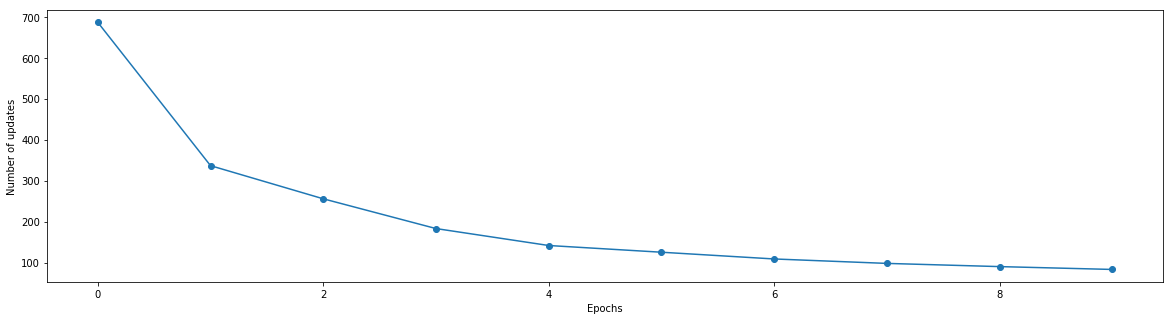

In [9]:
#print the error over epochs
plt.figure(figsize=(20,5)) #width, height settings for figures
plt.plot(range(0, n.ep), np.asfarray(n.E), marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
# plt.savefig('images/02_07.png', dpi=300)
plt.show()

# Knn implementation from the hiddeln layer data from ANN

# define the similarity

In [10]:
#Within our class we now need code for each of the components of k-NN.
#First, lets create a method that will measure the distance between two vectors.
def euclidean(instance1, instance2):
        '''
        Calculates euclidean distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):            
            distance += pow((val1 - val2), 2)
        
        distance = pow(distance, 1/2)
             
              
        return 1 / (1+ distance)
    

def manhattan(instance1, instance2):
        '''
        Calculates manhattan distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):
            distance += abs(val1 - val2)      
              
        return 1 / (1+ distance)
    
def dot_product(instance1, instance2):
        '''
        Calculates dot product between two instances 
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        return np.dot(instance1, instance2)

# define the met

In [11]:
    #Finally, we can test to see how many of the test instances we got correct
    def accuracy(results):
        correct = 0
        for predict, target in results:
            
            if predict == target:
                correct += 1
        return (correct/float(len(results))) * 100.0

# Build the KNN

In [12]:
class kNN:
    """
    Parameters
    X_train, Y_train : list
    these consists of the training set feature values and associated class labels
    k : int
    specify the number of neighbours
    sim : literal
    specify the name of the similarity metric (e.g. manhattan, eucliedean)
    weighted : Boolean
    specify the voting strategy as weighted or not weighted by similarity values
  
    Attributes
    -----------  
    Results : list
      Target and predicted class labels for the test data.    
    """


    def __init__(self, X_train, Y_train, k=3, sim=manhattan, weighted=False):
        self.X_train = X_train
        self.Y_train = Y_train
        
        if k <= len(self.X_train):
            self.k = k # set the k value for neighbourhood size
        else:
            self.k = len(self.X_train) # to ensure the get_neighbours dont crash
    
        self.similarity = sim # specify a sim metric that has been pre-defined e.g. manhattan or euclidean
        
        self.weighted = weighted # boolean to choose between weighted / unweighted majority voting
        
        #store results from testing 
        self.results= []
        
    #With k-NN, we are interested in finding the k number of points with the greatest similarity 
    # to the the query or test instance.
    def get_neighbours(self, test_instance):
        '''
        Locate most similar neighbours 
        X_train will be a containing features (Float) values (i.e. your training data)
        Y_train will be the corresponding class labels for each instance in X_train
        test_instance will be a List of Float values (i.e. a query instance)
        '''
        similarities = [] # collection to store the similarities to be computed

        for train_instance, y in zip(self.X_train, self.Y_train): #for each member of the training set
            sim = self.similarity(test_instance, train_instance) #calculate the similarity to the test instance
            
            similarities.append((y, sim)) #add the actual label of the example and the computed similarity to a collection 
        #print(distances)
        similarities.sort(key = operator.itemgetter(1), reverse = True) #sort the collection by decreasing similarity
        neighbours = [] # holds the k most similar neighbours
        for x in range(self.k): #extract the k top indices of the collection for return
            neighbours.append(similarities[x])

        return neighbours

    # given the neighbours make a prediction
    # the boolean parameter when set to False will use unweighted majority voting; otherwise weighted majority voting
    # weighting can be helpful to break any ties in voting
    def predict(self, neighbours):
        '''
        Summarise a prediction based upon weighted neighbours calculation
        '''
        class_votes = {}
        for x in range(len(neighbours)):
            response = neighbours[x][0]
            if response in class_votes:
                class_votes[response] += (1-self.weighted) + (self.weighted * neighbours[x][1]) #if not weighted simply add 1
                #class_votes[response] += [1, neighbours[x][1]][weighted == True] 
              
            else:
                class_votes[response] = (1-self.weighted) + (self.weighted * neighbours[x][1])
                #class_votes[response] = [1, neighbours[x][1]][weighted == True] 
                
        #print(class_votes)
        sorted_votes = sorted(class_votes, key = lambda k: (class_votes[k], k), reverse = True)
        #print(sorted_votes)
        return sorted_votes[0]
    
    #iterate through all the test data to calculate accuracy
    def test(self, X_test, Y_test):
        self.results = [] # store the predictions returned by kNN

        for test_instance, target_label in zip(X_test, Y_test):
            neighbours = self.get_neighbours(test_instance)
            predict_label = self.predict(neighbours)
            self.results.append([predict_label, target_label])
            #print('> predicted = ', result,', actual = ', test_label)
    

# Test the ANN and compute the Accuracy

In [13]:
n.test(mini_training_data, 'train')
n.test(test_data_list, 'test')


#print network performance as an accuracy metric
correct = 0 # number of predictions that were correct

#iteratre through each tested instance and accumilate number of correct predictions
for result in n.results:
    if (result[0] == result[1]):
            correct += 1
    pass
pass

# print the accuracy on test set
print ("Test set accuracy% = ", (100 * correct / len(n.results)))

Test set accuracy% =  82.0952380952381


# Checking the list sizes for KNN input from ANN hidden layer outputs

In [14]:
print(len(n.hidden_outputs_train))
print(len(n.hidden_outputs_test))
print(len(n.class_train))
print(len(n.class_test))

500
1050
500
1050


# Apply kNN

In [15]:
#create an instance of kNN 
# pass the training instances with their class labels (i.e. X_train and Y_train)
# we will use the default kNN class settings for parameters i.e. k=3, sim=manhattan, weighted=False

knn = kNN(n.hidden_outputs_train, n.class_train)
knn.test(n.hidden_outputs_test, n.class_test) # now get the predictions on the test set

print("kNN Accuracy on test set is: ", accuracy(knn.results))

kNN Accuracy on test set is:  84.85714285714285


# KNN with multiple values

In [16]:
print("Setup the kNN instances ...")
knn_list = []
ks = [1, 10, 20, 30, 40] # try a few different values for k
is_weighted = [False, True] # try two different forms of voting

# iterate over different voting strategies
for weighted in is_weighted:
    knn_list_element = [] # first set of knns with a specified voting scheme
    #iterate over different k values
    for k in ks:
        #create the different instances of the kNN class
        knn = kNN(n.hidden_outputs_train, n.class_train, k, euclidean, weighted)
        
        knn_list_element.append(knn)
        pass
    
    knn_list.append(knn_list_element)# now append the set of models 
    pass


#lets test the kNNs 
#iterate through each model and accumilate number of correct predictions
knn_results = []
knn_result_element = []

for knn1 in knn_list:
    knn_result_element = []

    for knn2 in knn1:
        knn2.test(n.hidden_outputs_test, n.class_test)
             
        knn_result_element.append(accuracy(knn2.results))
        
        pass
    pass
    knn_results.append(knn_result_element)
    pass
print("Results from trials...", knn_results)
         

Setup the kNN instances ...
Results from trials... [[85.52380952380952, 85.04761904761905, 83.9047619047619, 83.9047619047619, 83.14285714285714], [85.52380952380952, 85.71428571428571, 84.28571428571429, 84.19047619047619, 83.42857142857143]]


# Plot the results

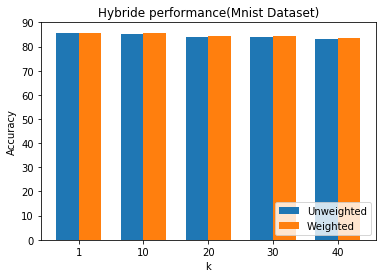

In [17]:
N = len(ks) # this is the number of results we want to plot pn the x-axis
ind = np.arange(N) 

performance1 = knn_results[0]
performance2 = knn_results[1]

width = 0.35 # width of the bar      
plt.bar(ind, performance1, width, label='Unweighted')
plt.bar(ind + width, performance2, width, label='Weighted')

plt.ylabel('Accuracy')
plt.xlabel('k')
plt.title('Hybride performance(Mnist Dataset)')

plt.xticks(ind + width / 2, ks)
plt.legend(loc='lower right')
plt.show()